In [26]:
# prvotni import

import torch
from torch.autograd import grad
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
import sys
from numpy import pi
from typing import Tuple, Dict
sys.path.append('..')

In [27]:
# vlastni import
from src import train, utils
from src import calculus as calc
import src.data.cube_domain as cb
from src.models.mlp_model import MLPModel

In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [30]:
# konstanty (parametry problemu)
ALPHA = 1.14
A = 2
B = 2
T_MAX = 1

In [31]:
l_bounds = [0, 0, 0]
u_bounds = [A, B, T_MAX]

plot_ctx = utils.PlotContext(
    l_bounds=l_bounds,
    u_bounds=u_bounds,
    patches=[],
    colour_map='inferno',
    vmin=-3,
    vmax=4,
    device=device,
    N=100
)

In [32]:
def initial_condition(x: torch.Tensor) -> torch.Tensor:
    return torch.sin(pi * x[:, 0:1] / A) * torch.sin(pi * x[:, 1:2] / B) - 3 * torch.sin(5 * pi * x[:, 0:1] / A) * torch.sin(5 * pi * x[:, 1:2] / B)

def analytical_solution(x: torch.Tensor) -> torch.Tensor:
    return torch.sin(pi * x[:, 0:1] / A) * torch.sin(pi * x[:, 1:2] / B) * torch.exp(-ALPHA * pi**2 * x[:, 2:3] * (A**2 + B**2) / ((A * B)**2)) +\
           (-3) * torch.sin(5 * pi * x[:, 0:1] / A) * torch.sin(5 * pi * x[:, 1:2] / B) * torch.exp(-ALPHA * 25 * pi**2 * x[:, 2:3] * (A**2 + B**2) / ((A * B)**2))

In [33]:
# moznost dale rozvijet tento zpusob sbirani loss?

pde_loss_values = []
initial_loss_values = []
boundary_loss_values = []
iteration = 0

def pde_residuum(pde_input: torch.Tensor, model: torch.nn.Module) -> torch.Tensor:
    # PDE ztrata:
    pde_output = model(pde_input)
    u_t = grad(pde_output, pde_input, torch.ones_like(pde_output), create_graph=True)[0][:, -1:]
    laplacian = calc.laplacian(pde_input, pde_output, device=device)
    return u_t - ALPHA * laplacian

first_iteration = True
temp_init_condition = lambda x: initial_condition(x)

def loss_fn(model: torch.nn.Module, domain: cb.CubeDomain) -> torch.Tensor:
    # PDE ztrata:
    pde_input = domain.interior.requires_grad_(True)
    pde_res = pde_residuum(pde_input, model)
    pde_loss = torch.mean((pde_res)**2)
    
    # ztrata na hranicich:
    side_input = domain.get_side_points(2).requires_grad_(True)
    side_output = model(side_input)
    side_loss = torch.mean(side_output**2)
    
    # ztrata na pocatku
    initial_input = domain.sides[-1][0].requires_grad_(True)
    init_output = model(initial_input)
    init_values = temp_init_condition(initial_input)
    init_loss = torch.mean((init_output - init_values)**2)

    # valid???
    global iteration
    if iteration % 100 == 99:
        pde_loss_values.append(pde_loss.item())
        boundary_loss_values.append(side_loss.item())
        initial_loss_values.append(init_loss.item())

    iteration += 1
    return pde_loss + side_loss + 1000 * init_loss


In [34]:
# priprava modelu
model_time_dict: Dict[torch.nn.Module, Tuple] = {
    MLPModel(3, 1, [64, 64, 64], l_bounds, u_bounds).to(device) : (0, 0.2),
    MLPModel(3, 1, [64, 64, 64], l_bounds, u_bounds).to(device) : (0.2, 0.4),
    MLPModel(3, 1, [64, 64, 64], l_bounds, u_bounds).to(device) : (0.4, 0.6),
    MLPModel(3, 1, [64, 64, 64], l_bounds, u_bounds).to(device) : (0.6, 0.8),
    MLPModel(3, 1, [64, 64, 64], l_bounds, u_bounds).to(device) : (0.8, 1.0),
}

In [35]:
# definice domeny
domain_ctx = cb.CubeContext(
    l_bounds=l_bounds,
    u_bounds=u_bounds,
    dim=3,
    N_int=2_000,
    N_sides=[(100, 100), (100, 100), (1_000, 100)],
    device=device
)

domain = cb.CubeDomain(domain_ctx)

In [36]:
train_ctx = train.TrainingContext(
    domain=domain,
    epochs=100,
    loss_fn=loss_fn,
    monitor_lr=True,
    monitor_gradient=True
)

loss_values = []

for i, (model, time) in enumerate(model_time_dict.items()):
    train_ctx.model = model
    train_ctx.optimizer = torch.optim.Adam(model.parameters(), lr=4e-3)
    train_ctx.scheduler = ReduceLROnPlateau(train_ctx.optimizer, factor=0.75, patience=200)

    domain.ctx.l_bounds[-1] = time[0]
    domain.ctx.u_bounds[-1] = time[1]

    loss_values += train.simple_train(train_ctx)
    prev_model = model
    temp_init_condition = lambda x: prev_model(x)

Loss at epoch 1 is: 2492.61279296875. Total gradient norm: 1378.6082069444512 Current learing rate: 0.004 
Loss at epoch 100 is: 2167.90234375. Total gradient norm: 166.65567351785725 Current learing rate: 0.004 
Loss at epoch 1 is: 238.9090118408203. Total gradient norm: 87.52305129291224 Current learing rate: 0.004 
Loss at epoch 100 is: 9.006596565246582. Total gradient norm: 96.4478288940522 Current learing rate: 0.004 
Loss at epoch 1 is: 684.7872924804688. Total gradient norm: 2503.5822258832236 Current learing rate: 0.004 
Loss at epoch 100 is: 8.890436172485352. Total gradient norm: 244.56031886222323 Current learing rate: 0.004 
Loss at epoch 1 is: 1604.2752685546875. Total gradient norm: 4131.983312125474 Current learing rate: 0.004 
Loss at epoch 100 is: 42.96648025512695. Total gradient norm: 166.45024419032015 Current learing rate: 0.004 
Loss at epoch 1 is: 1640.758056640625. Total gradient norm: 4077.0874387275276 Current learing rate: 0.004 
Loss at epoch 100 is: 16.107

ValueError: too many values to unpack (expected 2)

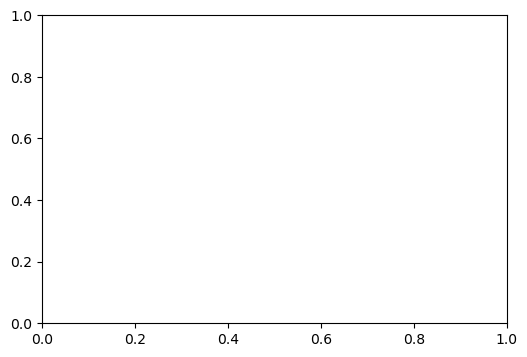

In [41]:
#initial_loss_values = [val.item() for val in initial_loss_values]

#utils.plot_loss_values(pde_loss_values, plot_ctx)
utils.plot_loss_values({'PDE loss' : pde_loss_values, 'Init loss' : initial_loss_values, 'Boundary loss' : boundary_loss_values}, plot_ctx)

/home/berva/anaconda3/envs/pytorch/lib/python3.12/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647329220/work/aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


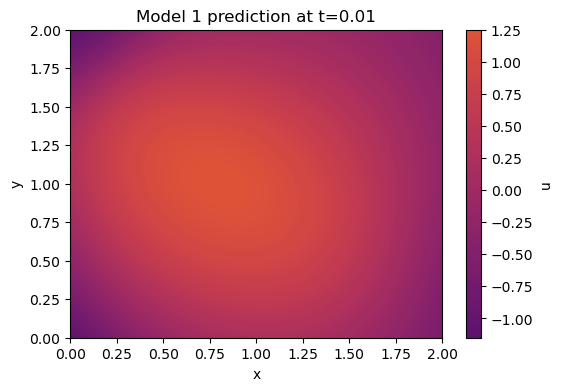

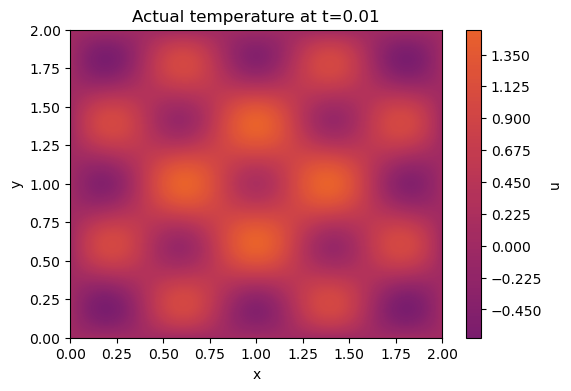

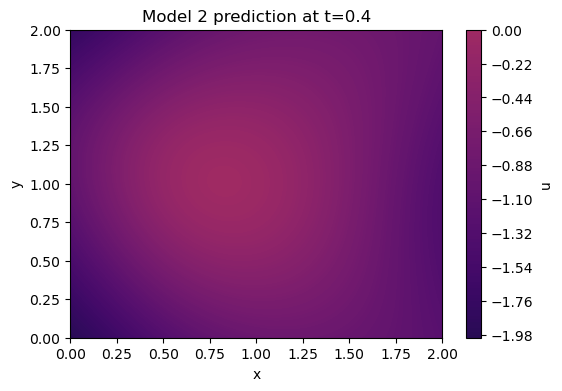

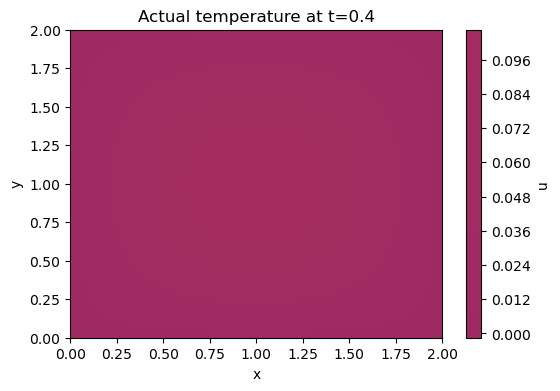

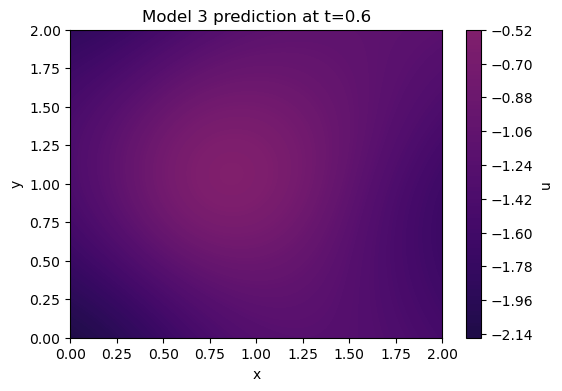

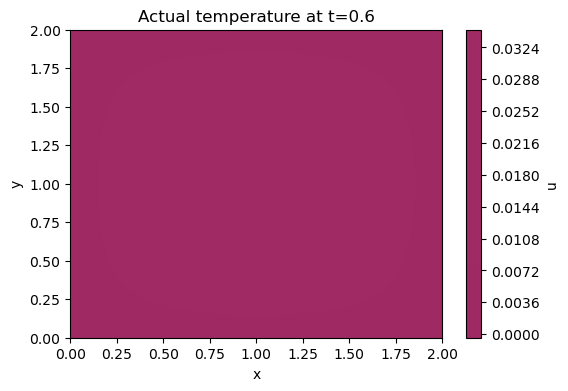

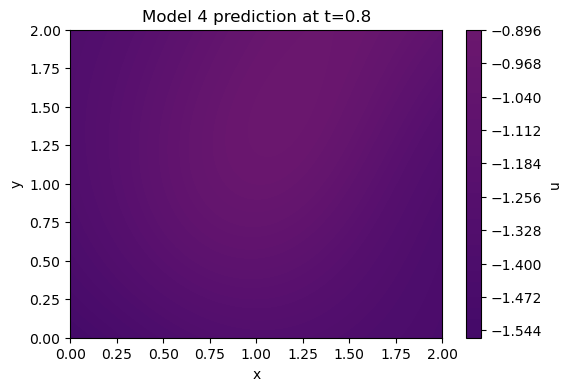

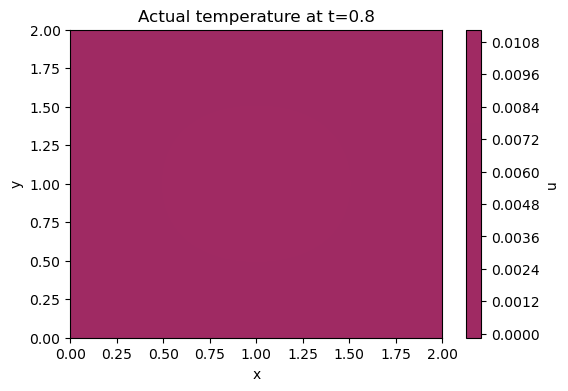

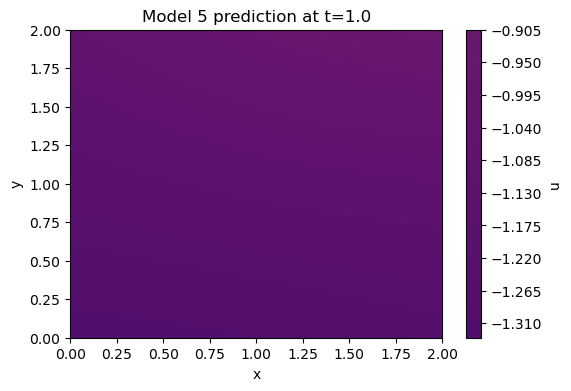

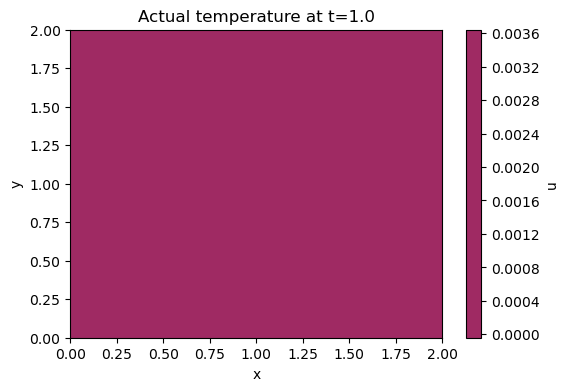

In [38]:
time_stamps = [0.01, 0.4, 0.6, 0.8, 1.0]

for i, model in enumerate(model_time_dict.keys()):
    plot_ctx.title = f'Model {i + 1} prediction at t={time_stamps[i]}'
    utils.plot_function_on_2d_cube(plot_ctx=plot_ctx, 
        function=lambda x: model(torch.cat( [x, torch.full( (x.shape[0], 1), time_stamps[i], device=device)], dim=1))
    )
    plot_ctx.title = f'Actual temperature at t={time_stamps[i]}'
    utils.plot_function_on_2d_cube(plot_ctx=plot_ctx, 
        function=lambda x: analytical_solution(torch.cat( [x, torch.full( (x.shape[0], 1), time_stamps[i], device=device)], dim=1))
    )

In [39]:
# A spocteme L2 chybu
torch.cuda.empty_cache()
l2_error = 0

for i, (model, time) in enumerate(model_time_dict.items()):
    partial_l2_error = calc.L2_norm(analytical_solution, model, 3, [2, 2, time[1]], [0, 0, time[0]], device=device, n=50)**2
    l2_error += partial_l2_error
    print(f'L2 chyba modelu {i + 1} je {torch.sqrt(partial_l2_error)}')

print(f"Celkova L2 chyba reseni je {torch.sqrt(l2_error)}")

L2 chyba modelu 1 je 0.36640965938568115
L2 chyba modelu 2 je 0.5808619856834412
L2 chyba modelu 3 je 0.9404525756835938
L2 chyba modelu 4 je 1.0525225400924683
L2 chyba modelu 5 je 1.0431510210037231
Celkova L2 chyba reseni je 1.884695053100586
